# Business Problem
#### prepare a project to show home sellers how to price homes theyre having built based on data already known of similar homes. (CMA)

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Open data

In [2]:
df=pd.read_csv('data/kc_house_data.csv',  index_col='id')
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  object 
 8   view           21534 non-null  object 
 9   condition      21597 non-null  object 
 10  grade          21597 non-null  object 
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  object 
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17755 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float

In [4]:
# One-hot encoding 'condition' and 'view' columns

condition = df[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(condition)
condition_enc = ohe.transform(condition)
condition_enc = pd.DataFrame(condition_enc,
                             columns=['cond_avg','cond_fair','cond_good','cond_poor','cond_verygood'],
                             index=df.index)
df.drop('condition', axis=1, inplace=True)
df = pd.concat([df, condition_enc], axis=1)

In [5]:
# Fill in missing data
df['waterfront'] = df['waterfront'].fillna('NO')
df['waterfront'] = df['waterfront'].str.replace('NO', '0')
df['waterfront'] = df['waterfront'].str.replace('YES', '1')
df['waterfront'] = pd.to_numeric(df['waterfront'])
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['view'] = df['view'].fillna('NONE')
df['grade'] = df['grade'].str.replace('7 Average', '7')
df['grade'] = df['grade'].str.replace('8 Good', '8')
df['grade'] = df['grade'].str.replace('9 Better', '9')
df['grade'] = df['grade'].str.replace('6 Low Average', '6')
df['grade'] = df['grade'].str.replace('10 Very Good', '10')
df['grade'] = df['grade'].str.replace('11 Excellent', '11')
df['grade'] = df['grade'].str.replace('5 Fair', '5')
df['grade'] = df['grade'].str.replace('12 Luxury', '12')
df['grade'] = df['grade'].str.replace('4 Low', '4')
df['grade'] = df['grade'].str.replace('13 Mansion', '13')
df['grade'] = df['grade'].str.replace('3 Poor', '3')
df['grade'] = pd.to_numeric(df['grade'])
df['bedrooms'].replace(33, 3, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 7129300520 to 1523300157
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  object 
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   21597 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64

In [7]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,yr_built,...,zipcode,lat,long,sqft_living15,sqft_lot15,cond_avg,cond_fair,cond_good,cond_poor,cond_verygood
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.371811,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,7.657915,1788.596842,1970.999676,...,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,0.649164,0.007871,0.262861,0.001343,0.078761
std,3.673681e+05,0.904096,0.768984,918.106125,4.141264e+04,0.539683,0.081944,1.173200,827.759761,29.375234,...,53.513072,0.138552,0.140724,685.230472,27274.441950,0.477243,0.088373,0.440198,0.036620,0.269372
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,3.000000,370.000000,1900.000000,...,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,7.000000,1190.000000,1951.000000,...,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,7.000000,1560.000000,1975.000000,...,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,8.000000,2210.000000,1997.000000,...,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,13.000000,9410.000000,2015.000000,...,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
#checking to see whats correlated at a point of .7 or above
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,yr_built,...,zipcode,lat,long,sqft_living15,sqft_lot15,cond_avg,cond_fair,cond_good,cond_poor,cond_verygood
price,1.000000,0.315954,0.525906,0.701917,0.089876,0.256804,0.264306,0.667951,0.605368,0.053953,...,-0.053402,0.306692,0.022036,0.585241,0.082845,0.006948,-0.051432,-0.030759,-0.019886,0.057531
bedrooms,0.315954,1.000000,0.527874,0.593182,0.033606,0.183721,-0.002053,0.366181,0.492549,0.160748,...,-0.158596,-0.011612,0.136574,0.404540,0.031898,0.007428,-0.050541,-0.009165,-0.033262,0.022921
bathrooms,0.525906,0.527874,1.000000,0.755758,0.088373,0.502582,0.063629,0.665838,0.686668,0.507173,...,-0.204786,0.024280,0.224903,0.569884,0.088303,0.190790,-0.075933,-0.166756,-0.042932,-0.034765
sqft_living,0.701917,0.593182,0.755758,1.000000,0.173453,0.353953,0.104637,0.762779,0.876448,0.318152,...,-0.199802,0.052155,0.241214,0.756402,0.184342,0.102061,-0.063984,-0.083850,-0.033246,-0.018284
sqft_lot,0.089876,0.033606,0.088373,0.173453,1.000000,-0.004814,0.021459,0.114731,0.184139,0.052946,...,-0.129586,-0.085514,0.230227,0.144763,0.718204,-0.011589,0.037871,0.013284,0.006265,-0.014452
floors,0.256804,0.183721,0.502582,0.353953,-0.004814,1.000000,0.020797,0.458794,0.523989,0.489193,...,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.317725,-0.055337,-0.257672,-0.023029,-0.120546
waterfront,0.264306,-0.002053,0.063629,0.104637,0.021459,0.020797,1.000000,0.082818,0.071778,-0.024487,...,0.028923,-0.012157,-0.037628,0.083823,0.030658,-0.017498,-0.000954,0.009785,0.012406,0.013637
grade,0.667951,0.366181,0.665838,0.762779,0.114731,0.458794,0.082818,1.000000,0.756073,0.447865,...,-0.185771,0.113575,0.200341,0.713867,0.120981,0.196419,-0.084788,-0.140140,-0.052897,-0.083974
sqft_above,0.605368,0.492549,0.686668,0.876448,0.184139,0.523989,0.071778,0.756073,1.000000,0.424037,...,-0.261570,-0.001199,0.344842,0.731767,0.195077,0.194238,-0.057698,-0.142520,-0.027236,-0.088596
yr_built,0.053953,0.160748,0.507173,0.318152,0.052946,0.489193,-0.024487,0.447865,0.424037,1.000000,...,-0.347210,-0.148370,0.409993,0.326377,0.070777,0.391418,-0.066977,-0.257155,-0.050621,-0.244382


<AxesSubplot:>

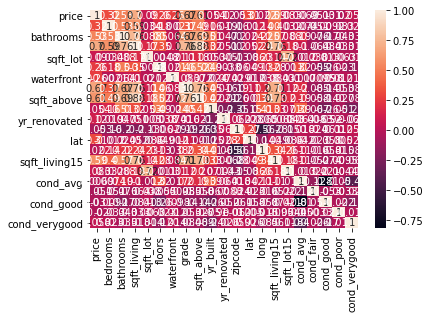

In [9]:
sns.heatmap(df.corr(),annot=True)

sqft is where most correlation happens i want low correlations to pick the variables im using.

In [10]:
# calculate summary statistics
df_mean = np.mean(df['price'])
df_std =  np.std(df['price'])
# identify outliers
cut_off = df_std * 3

In [11]:
lower, upper = df_mean - cut_off, df_mean + cut_off

In [12]:
# identify outliers
df= df[(df['price']> lower) & (df['price']<upper)]
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,cond_avg,cond_fair,cond_good,cond_poor,cond_verygood
id,,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,NONE,7,...,98178,47.5112,-122.257,1340,5650,1.0,0.0,0.0,0.0,0.0
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,NONE,7,...,98125,47.7210,-122.319,1690,7639,1.0,0.0,0.0,0.0,0.0
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,NONE,6,...,98028,47.7379,-122.233,2720,8062,1.0,0.0,0.0,0.0,0.0
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,NONE,7,...,98136,47.5208,-122.393,1360,5000,0.0,0.0,0.0,0.0,1.0
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,NONE,8,...,98074,47.6168,-122.045,1800,7503,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0,NONE,8,...,98103,47.6993,-122.346,1530,1509,1.0,0.0,0.0,0.0,0.0
6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0,NONE,8,...,98146,47.5107,-122.362,1830,7200,1.0,0.0,0.0,0.0,0.0
1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0,NONE,7,...,98144,47.5944,-122.299,1020,2007,1.0,0.0,0.0,0.0,0.0


method gets rid of the the extreme values (~0.3%) and leaves 99.7% of the rest of the data.

## Data analysis

In [13]:
df.drop(['sqft_basement', 'date'], axis=1, inplace=True)

dropping sqft basement and date to get a more readable ols model

In [14]:
# Analyzing OLS results

outcome = 'price'
dfx = df.drop('price', axis=1)
predictors = '+'.join(dfx.columns)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     2293.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:33   Log-Likelihood:            -2.8099e+05
No. Observations:               21191   AIC:                         5.620e+05
Df Residuals:                   21167   BIC:                         5.622e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.727e+06   1.71e+06     -1.008      0.313   -5.08e+06    1.63e+06
view[T.EXCELLENT]  1.171e+05   1.17e+04      9.996      0.000    9.41e+04     1.4e+05
view[T.FAIR]        1.85e+04   9204.359      2.010      0.044     456.966    3.65e+04
view[T.GOOD]        5.44e+04   8040.073      6.767      0.000    3.86e+04    7.02e+04
view[T.NONE]      -7.023e+04   4878.391    -14.396      0.000   -7.98e+04   -6.07e+04
bedrooms          -1.541e+04   1402.522    -10.987      0.000   -1.82e+04   -1.27e+04
bathrooms          2.873e+04   2317.177     12.400      0.000    2.42e+04    3.33e+04
sqft_living          89.8093      3.205     28.022      0.000      83.527      96.091
sqft_lot              0.1822      0.034      5.317      0.000       0.115       0.249
floors              3.13e+04   2546.205     12.292      0.000    2.63e+04    3.63e+04
waterfront         1.916e+05   1.79e+04     10.718      0.000    1.57e+05    2.27e+05
grade              8.806e+04   1528.082     57.627      0.000    8.51e+04    9.11e+04
sqft_above            2.3871      3.138      0.761      0.447      -3.764       8.539
yr_built          -2134.5966     51.116    -41.760      0.000   -2234.788   -2034.405
yr_renovated         19.7333      2.846      6.935      0.000      14.156      25.311
zipcode            -353.5123     23.162    -15.262      0.000    -398.912    -308.112
lat                5.689e+05   7457.600     76.285      0.000    5.54e+05    5.84e+05
long              -1.101e+05   9175.852    -11.999      0.000   -1.28e+05   -9.21e+04
sqft_living15        47.5520      2.510     18.945      0.000      42.632      52.472
sqft_lot15           -0.1634      0.051     -3.184      0.001      -0.264      -0.063
cond_avg          -3.569e+05   3.43e+05     -1.041      0.298   -1.03e+06    3.15e+05
cond_fair         -3.643e+05   3.43e+05     -1.063      0.288   -1.04e+06    3.08e+05
cond_good         -3.326e+05   3.42e+05     -0.971      0.331      -1e+06    3.39e+05
cond_poor         -3.785e+05   3.43e+05     -1.103      0.270   -1.05e+06    2.94e+05
cond_verygood     -2.941e+05   3.42e+05     -0.859      0.390   -9.65e+05    3.77e+05
==============================================================================
Omnibus:                     4718.991   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18151.670
Skew:                           1.072   Prob(JB):                         0.00
Kurtosis:                       6.996   Cond. No.                     2.60e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.18e-23. This might indicate that there are
strong multicollinearity 

In [15]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,cond_avg,cond_fair,cond_good,cond_poor,cond_verygood
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,NONE,7,1180,...,98178,47.5112,-122.257,1340,5650,1.0,0.0,0.0,0.0,0.0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,NONE,7,2170,...,98125,47.7210,-122.319,1690,7639,1.0,0.0,0.0,0.0,0.0
5631500400,180000.0,2,1.00,770,10000,1.0,0,NONE,6,770,...,98028,47.7379,-122.233,2720,8062,1.0,0.0,0.0,0.0,0.0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,NONE,7,1050,...,98136,47.5208,-122.393,1360,5000,0.0,0.0,0.0,0.0,1.0
1954400510,510000.0,3,2.00,1680,8080,1.0,0,NONE,8,1680,...,98074,47.6168,-122.045,1800,7503,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,360000.0,3,2.50,1530,1131,3.0,0,NONE,8,1530,...,98103,47.6993,-122.346,1530,1509,1.0,0.0,0.0,0.0,0.0
6600060120,400000.0,4,2.50,2310,5813,2.0,0,NONE,8,2310,...,98146,47.5107,-122.362,1830,7200,1.0,0.0,0.0,0.0,0.0
1523300141,402101.0,2,0.75,1020,1350,2.0,0,NONE,7,1020,...,98144,47.5944,-122.299,1020,2007,1.0,0.0,0.0,0.0,0.0


In [16]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,yr_built,...,zipcode,lat,long,sqft_living15,sqft_lot15,cond_avg,cond_fair,cond_good,cond_poor,cond_verygood
count,2.119100e+04,21191.000000,21191.000000,21191.000000,2.119100e+04,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,...,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000,21191.000000
mean,5.070103e+05,3.354679,2.087514,2032.486103,1.482673e+04,1.486858,0.003775,7.605304,1751.498938,1970.926525,...,98078.289651,47.558989,-122.213732,1960.388656,12631.720589,0.649568,0.007975,0.263414,0.001369,0.077674
std,2.594622e+05,0.894644,0.736021,836.738586,4.040095e+04,0.538297,0.061328,1.108906,772.205310,29.285262,...,53.407481,0.139455,0.141433,655.151335,27193.757002,0.477116,0.088949,0.440495,0.036969,0.267665
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,3.000000,370.000000,1900.000000,...,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000e+05,3.000000,1.500000,1410.000000,5.005500e+03,1.000000,0.000000,7.000000,1190.000000,1951.000000,...,98033.000000,47.467050,-122.329000,1480.000000,5080.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.470000e+05,3.000000,2.250000,1890.000000,7.560000e+03,1.000000,0.000000,7.000000,1544.000000,1975.000000,...,98065.000000,47.569900,-122.231000,1820.000000,7576.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.276500e+05,4.000000,2.500000,2500.000000,1.049050e+04,2.000000,0.000000,8.000000,2170.000000,1996.000000,...,98118.000000,47.678800,-122.124000,2330.000000,10000.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.640000e+06,11.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,12.000000,7320.000000,2015.000000,...,98199.000000,47.777600,-121.315000,5790.000000,871200.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling process

### baseline model (dummy regressor)

In [17]:
X=df.drop('price',axis=1) 
Y=df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [18]:
X_train.shape

(15893, 21)

In [19]:
#creating dummy regressor thats the mean of Y(price)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, Y_train)
DummyRegressor()
dummy_regr.predict(X_train)


array([505467.55294784, 505467.55294784, 505467.55294784, ...,
       505467.55294784, 505467.55294784, 505467.55294784])

In [20]:
dummy_regr.score(X_train, Y_train)

0.0

Text(0, 0.5, 'Predicted Price')

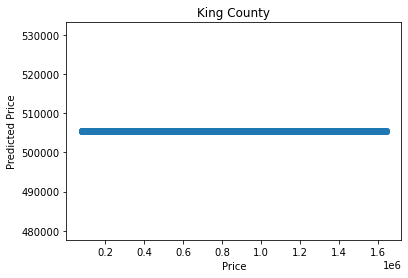

In [21]:
plt.scatter(Y_train,dummy_regr.predict(X_train))
plt.title('King County')
plt.xlabel('Price')
plt.ylabel('Predicted Price')

### first simple model(only using sqft lot)


Simple LR Train R²: 0.008214473164270819
Simple LR Test R²: 0.008429261533757337
Simple LR Train RMSE: 258006.8027168702
Simple LR Test RMSE: 259814.97999606028


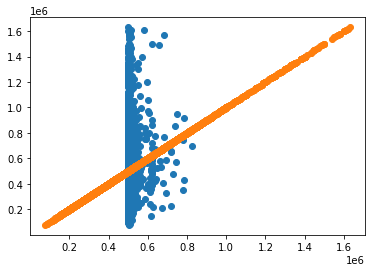

In [22]:
#predictive model
y1= df['price']
X1=df[['sqft_lot']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,
                                                    test_size=0.2,
                                                    random_state=42)
lr1= LinearRegression()
lr1.fit(X_train1,y_train1)
y_hat_train1 = lr1.predict(X_train1)
y_hat_test1 = lr1.predict(X_test1)
train_rmse = mse(y_train1, y_hat_train1, squared=False)
test_rmse = mse(y_test1, y_hat_test1, squared=False)
print('Simple LR Train R\u00b2:', lr1.score(X_train1, y_train1))
print('Simple LR Test R\u00b2:', lr1.score(X_test1, y_test1))
print('Simple LR Train RMSE:', train_rmse)
print('Simple LR Test RMSE:', test_rmse)
y1_test_pred = lr1.predict(X_test1)
plt.scatter(y1_test_pred, y_test1)
plt.scatter(y_test1, y_test1);

In [23]:
lr1.score(X_test1, y_test1)

0.008429261533757337

In [24]:
#inferential model
X1 = sm.add_constant(X1)
model = sm.OLS(y1,X1)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     179.3
Date:                Sun, 21 Nov 2021   Prob (F-statistic):           1.01e-40
Time:                        18:33:34   Log-Likelihood:            -2.9415e+05
No. Observations:               21191   AIC:                         5.883e+05
Df Residuals:                   21189   BIC:                         5.883e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.983e+05   1890.675    263.550      0.000    4.95e+05    5.02e+05
sqft_lot       0.5883      0.044     13.391      0.000       0.502       0.674
==============================================================================
Omnibus:                     5168.044   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11773.805
Skew:                           1.387   Prob(JB):                         0.00
Kurtosis:                       5.375   Cond. No.                     4.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### multiple linear regression model (3 variables)

LR2 Train R²: 0.2502831717825783
LR2 Test R²: 0.26729142743983336
LR2 Train RMSE: 224321.5015392553
LR2 Test RMSE: 223340.75123922742


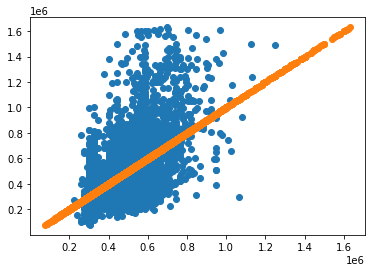

In [25]:

y2= df['price']
X2=df[['sqft_lot', 'bedrooms', 'bathrooms']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                    test_size=0.2,
                                                    random_state=42)
lr2= LinearRegression()
lr2.fit(X_train2,y_train2)
y_hat_train2 = lr2.predict(X_train2)
y_hat_test2 = lr2.predict(X_test2)
train_rmse2 = mse(y_train2, y_hat_train2, squared=False)
test_rmse2 = mse(y_test2, y_hat_test2, squared=False)
print('LR2 Train R\u00b2:', lr2.score(X_train2, y_train2))
print('LR2 Test R\u00b2:', lr2.score(X_test2, y_test2))
print('LR2 Train RMSE:', train_rmse2)
print('LR2 Test RMSE:', test_rmse2)
y2_test_pred = lr2.predict(X_test2)
plt.scatter(y2_test_pred, y_test2)
plt.scatter(y_test2, y_test2);

In [26]:
lr2.score(X_test2, y_test2)

0.26729142743983336

In [27]:
X2 = sm.add_constant(X_train2)
model2ols = sm.OLS(y_train2,X2)
results = model2ols.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1886.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:34   Log-Likelihood:            -2.3292e+05
No. Observations:               16952   AIC:                         4.658e+05
Df Residuals:                   16948   BIC:                         4.659e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.223e+04   6924.987     13.318      0.000    7.87e+04    1.06e+05
sqft_lot       0.3358      0.042      8.011      0.000       0.254       0.418
bedrooms    2.443e+04   2243.113     10.892      0.000       2e+04    2.88e+04
bathrooms   1.567e+05   2741.128     57.149      0.000    1.51e+05    1.62e+05
==============================================================================
Omnibus:                     3332.036   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7021.997
Skew:                           1.157   Prob(JB):                         0.00
Kurtosis:                       5.143   Cond. No.                     1.81e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the R^2 i can tell this is a better model than the first.

### multiple linear regression (5 variables)

LR3 Train R²: 0.45410314983126243
LR3 Test R²: 0.4538118528774695
LR3 Train RMSE: 191415.70530323786
LR3 Test RMSE: 192829.49854673265


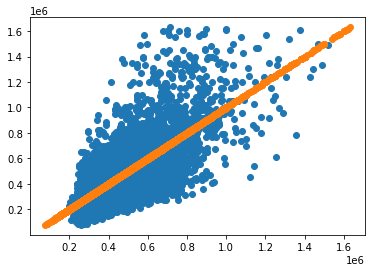

In [28]:

y3= df['price']
X3=df[['sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_living']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3,
                                                    test_size=0.2,
                                                    random_state=42)
lr3= LinearRegression()
lr3.fit(X_train3,y_train3)
y_hat_train3 = lr3.predict(X_train3)
y_hat_test3 = lr3.predict(X_test3)
train_rmse3 = mse(y_train3, y_hat_train3, squared=False)
test_rmse3 = mse(y_test3, y_hat_test3, squared=False)
print('LR3 Train R\u00b2:', lr3.score(X_train3, y_train3))
print('LR3 Test R\u00b2:', lr3.score(X_test3, y_test3))
print('LR3 Train RMSE:', train_rmse3)
print('LR3 Test RMSE:', test_rmse3)
y3_test_pred = lr3.predict(X_test3)
plt.scatter(y3_test_pred, y_test3)
plt.scatter(y_test3, y_test3);

In [29]:
lr3.score(X_test3, y_test3)

0.4538118528774695

In [30]:
X3 = sm.add_constant(X3)
model3 = sm.OLS(y3,X3)
results = model3.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     3525.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:34   Log-Likelihood:            -2.8783e+05
No. Observations:               21191   AIC:                         5.757e+05
Df Residuals:                   21185   BIC:                         5.757e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.389e+05   5909.620     23.498      0.000    1.27e+05     1.5e+05
sqft_lot       -0.1738      0.033     -5.215      0.000      -0.239      -0.109
bedrooms    -3.628e+04   1875.780    -19.339      0.000      -4e+04   -3.26e+04
bathrooms    3736.6235   2914.595      1.282      0.200   -1976.204    9449.451
floors       1.999e+04   2860.613      6.988      0.000    1.44e+04    2.56e+04
sqft_living   223.8107      2.551     87.726      0.000     218.810     228.811
==============================================================================
Omnibus:                     3669.608   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8233.669
Skew:                           1.005   Prob(JB):                         0.00
Kurtosis:                       5.300   Cond. No.                     2.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

better model but still could be better because bedroom coef is negative.

### multiple linear regression (6 variables)

LR4 Train R²: 0.45981179408606365
LR4 Test R²: 0.4661010668954142
LR4 Train RMSE: 190412.22272578982
LR4 Test RMSE: 190647.82840145298


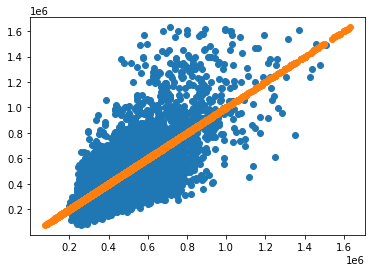

In [31]:
y4= df['price']
X4=df[['sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'waterfront' ]]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4,
                                                    test_size=0.2,
                                                    random_state=42)
lr4= LinearRegression()
lr4.fit(X_train4,y_train4)
y_hat_train4 = lr4.predict(X_train4)
y_hat_test4 = lr4.predict(X_test4)
train_rmse4 = mse(y_train4, y_hat_train4, squared=False)
test_rmse4 = mse(y_test4, y_hat_test4, squared=False)
print('LR4 Train R\u00b2:', lr4.score(X_train4, y_train4))
print('LR4 Test R\u00b2:', lr4.score(X_test4, y_test4))
print('LR4 Train RMSE:', train_rmse4)
print('LR4 Test RMSE:', test_rmse4)
y4_test_pred = lr4.predict(X_test4)
plt.scatter(y4_test_pred, y_test4)
plt.scatter(y_test4, y_test4);

In [32]:
lr4.score(X_test4, y_test4)

0.4661010668954142

In [33]:
X4 = sm.add_constant(X4)
model4 = sm.OLS(y4,X4)
results = model4.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     3023.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:34   Log-Likelihood:            -2.8769e+05
No. Observations:               21191   AIC:                         5.754e+05
Df Residuals:                   21184   BIC:                         5.754e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.347e+05   5876.361     22.929      0.000    1.23e+05    1.46e+05
sqft_lot       -0.1823      0.033     -5.505      0.000      -0.247      -0.117
bedrooms    -3.468e+04   1866.025    -18.584      0.000   -3.83e+04    -3.1e+04
bathrooms    3638.9516   2895.637      1.257      0.209   -2036.716    9314.620
floors       2.037e+04   2842.091      7.167      0.000    1.48e+04    2.59e+04
sqft_living   222.4260      2.536     87.707      0.000     217.455     227.397
waterfront   3.572e+05   2.14e+04     16.715      0.000    3.15e+05    3.99e+05
==============================================================================
Omnibus:                     3499.776   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7659.397
Skew:                           0.972   Prob(JB):                         0.00
Kurtosis:                       5.213   Cond. No.                     7.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### multiple linear regression (11 variables)

LR5 Train R²: 0.4711914056948029
LR5 Test R²: 0.47783842687020317
LR5 Train RMSE: 188395.9342638528
LR5 Test RMSE: 188540.55896569285


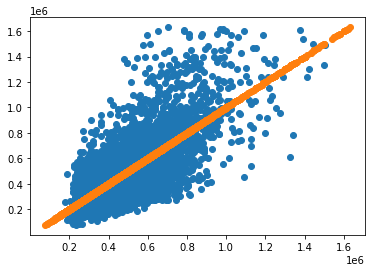

In [34]:
y5= df['price']
X5=df[['sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'waterfront', 'cond_avg', 'cond_fair', 'cond_good', 'cond_poor', 'cond_verygood' ]]

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5,
                                                    test_size=0.2,
                                                    random_state=42)
lr5= LinearRegression()
lr5.fit(X_train5,y_train5)
y_hat_train5 = lr5.predict(X_train5)
y_hat_test5 = lr5.predict(X_test5)
train_rmse5 = mse(y_train5, y_hat_train5, squared=False)
test_rmse5 = mse(y_test5, y_hat_test5, squared=False)
print('LR5 Train R\u00b2:', lr5.score(X_train5, y_train5))
print('LR5 Test R\u00b2:', lr5.score(X_test5, y_test5))
print('LR5 Train RMSE:', train_rmse5)
print('LR5 Test RMSE:', test_rmse5)
y5_test_pred = lr5.predict(X_test5)
plt.scatter(y5_test_pred, y_test5)
plt.scatter(y_test5, y_test5);

In [35]:
lr5.score(X_test5, y_test5)

0.47783842687020317

In [36]:
X5 = sm.add_constant(X5)
model5 = sm.OLS(y5,X5)
results = model5.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     1899.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:34   Log-Likelihood:            -2.8746e+05
No. Observations:               21191   AIC:                         5.749e+05
Df Residuals:                   21180   BIC:                         5.750e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.033e+05   7744.525     13.333      0.000    8.81e+04    1.18e+05
sqft_lot         -0.1749      0.033     -5.328      0.000      -0.239      -0.111
bedrooms      -3.733e+04   1851.835    -20.156      0.000    -4.1e+04   -3.37e+04
bathrooms      5378.2642   2876.315      1.870      0.062    -259.532     1.1e+04
floors         3.379e+04   2906.778     11.623      0.000    2.81e+04    3.95e+04
sqft_living     222.3062      2.510     88.557      0.000     217.386     227.227
waterfront     3.494e+05   2.12e+04     16.516      0.000    3.08e+05    3.91e+05
cond_avg       -203.8671   6729.740     -0.030      0.976   -1.34e+04     1.3e+04
cond_fair     -3.366e+04   1.35e+04     -2.498      0.012   -6.01e+04   -7252.304
cond_good      3.683e+04   6799.854      5.416      0.000    2.35e+04    5.02e+04
cond_poor      1896.3535   2.93e+04      0.065      0.948   -5.55e+04    5.93e+04
cond_verygood   9.84e+04   7531.223     13.066      0.000    8.36e+04    1.13e+05
==============================================================================
Omnibus:                     3451.164   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7648.505
Skew:                           0.955   Prob(JB):                         0.00
Kurtosis:                       5.239   Cond. No.                     1.21e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.67e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### multiple linear regression (12 variables)

LR6 Train R²: 0.5420638321965803
LR6 Test R²: 0.5520952238421426
LR6 Train RMSE: 175317.28904392506
LR6 Test RMSE: 174620.4821369481


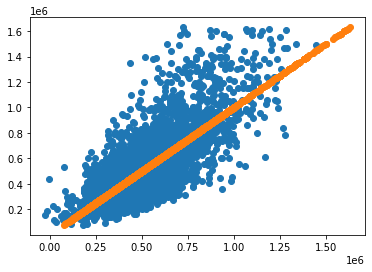

In [37]:
y6= df['price']
X6=df[['sqft_lot', 'bedrooms', 'bathrooms', 'floors', 'sqft_living', 'waterfront', 'cond_avg', 'cond_fair', 'cond_good', 'cond_poor', 'cond_verygood', 'grade' ]]

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6,
                                                    test_size=0.2,
                                                    random_state=42)
lr6= LinearRegression()
lr6.fit(X_train6,y_train6)
y_hat_train6 = lr6.predict(X_train6)
y_hat_test6 = lr6.predict(X_test6)
train_rmse6 = mse(y_train6, y_hat_train6, squared=False)
test_rmse6 = mse(y_test6, y_hat_test6, squared=False)
print('LR6 Train R\u00b2:', lr6.score(X_train6, y_train6))
print('LR6 Test R\u00b2:', lr6.score(X_test6, y_test6))
print('LR6 Train RMSE:', train_rmse6)
print('LR6 Test RMSE:', test_rmse6)
y6_test_pred = lr6.predict(X_test6)
plt.scatter(y6_test_pred, y_test6)
plt.scatter(y_test6, y_test6);

In [38]:
lr6.score(X_test6, y_test6)

0.5520952238421426

In [39]:
X6 = sm.add_constant(X6)
model6 = sm.OLS(y6,X6)
results = model6.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     2299.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:35   Log-Likelihood:            -2.8592e+05
No. Observations:               21191   AIC:                         5.719e+05
Df Residuals:                   21179   BIC:                         5.720e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.366e+05   1.05e+04    -32.087      0.000   -3.57e+05   -3.16e+05
sqft_lot         -0.1421      0.031     -4.658      0.000      -0.202      -0.082
bedrooms      -1.878e+04   1751.444    -10.725      0.000   -2.22e+04   -1.54e+04
bathrooms     -1.487e+04   2697.097     -5.513      0.000   -2.02e+04   -9582.012
floors         -258.2468   2766.210     -0.093      0.926   -5680.228    5163.734
sqft_living     133.4795      2.796     47.731      0.000     127.998     138.961
waterfront     3.572e+05   1.97e+04     18.165      0.000    3.19e+05    3.96e+05
cond_avg      -1.201e+05   6593.211    -18.216      0.000   -1.33e+05   -1.07e+05
cond_fair     -1.115e+05   1.26e+04     -8.849      0.000   -1.36e+05   -8.68e+04
cond_good     -7.409e+04   6608.088    -11.212      0.000    -8.7e+04   -6.11e+04
cond_poor      -3.25e+04   2.72e+04     -1.193      0.233   -8.59e+04    2.09e+04
cond_verygood  1607.8414   7200.277      0.223      0.823   -1.25e+04    1.57e+04
grade          1.007e+05   1746.413     57.660      0.000    9.73e+04    1.04e+05
==============================================================================
Omnibus:                     3462.124   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7893.267
Skew:                           0.947   Prob(JB):                         0.00
Kurtosis:                       5.313   Cond. No.                     1.12e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.15e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### multiple linear regression (13 variables)

LR7 Train R²: 0.5537667895679715
LR7 Test R²: 0.5653236673970339
LR7 Train RMSE: 173062.59770299657
LR7 Test RMSE: 172022.53105122852


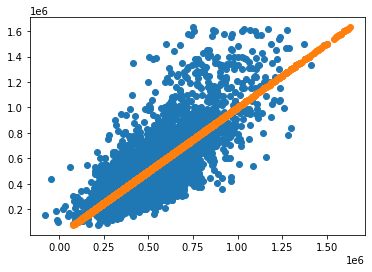

In [40]:
y7= df['price']
X7=df[['sqft_lot', 'bedrooms', 'bathrooms', 'floors','sqft_living', 'waterfront','cond_avg', 'cond_fair', 'cond_good', 'cond_poor', 'cond_verygood', 'grade', 'zipcode' ]]

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7,
                                                    test_size=0.2,
                                                    random_state=42)
lr7= LinearRegression()
lr7.fit(X_train7,y_train7)
y_hat_train7 = lr7.predict(X_train7)
y_hat_test7 = lr7.predict(X_test7)
train_rmse7 = mse(y_train7, y_hat_train7, squared=False)
test_rmse7 = mse(y_test7, y_hat_test7, squared=False)
print('LR7 Train R\u00b2:', lr7.score(X_train7, y_train7))
print('LR7 Test R\u00b2:', lr7.score(X_test7, y_test7))
print('LR7 Train RMSE:', train_rmse7)
print('LR7 Test RMSE:', test_rmse7)
y7_test_pred = lr7.predict(X_test7)
plt.scatter(y7_test_pred, y_test7)
plt.scatter(y_test7, y_test7);

In [41]:
lr7.score(X_test7, y_test7)

0.5653236673970339

In [42]:
X7 = sm.add_constant(X7)
model7 = sm.OLS(y7,X7)
results = model7.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     2212.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:35   Log-Likelihood:            -2.8563e+05
No. Observations:               21191   AIC:                         5.713e+05
Df Residuals:                   21178   BIC:                         5.714e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.562e+07   1.89e+06    -24.123      0.000   -4.93e+07   -4.19e+07
sqft_lot         -0.0637      0.030     -2.104      0.035      -0.123      -0.004
bedrooms      -1.706e+04   1729.755     -9.860      0.000   -2.04e+04   -1.37e+04
bathrooms     -9084.2718   2672.314     -3.399      0.001   -1.43e+04   -3846.333
floors        -2719.1741   2731.505     -0.995      0.320   -8073.133    2634.784
sqft_living     133.5239      2.759     48.388      0.000     128.115     138.933
waterfront     3.341e+05   1.94e+04     17.194      0.000    2.96e+05    3.72e+05
cond_avg      -9.176e+06   3.78e+05    -24.259      0.000   -9.92e+06   -8.43e+06
cond_fair     -9.169e+06   3.78e+05    -24.227      0.000   -9.91e+06   -8.43e+06
cond_good     -9.125e+06   3.78e+05    -24.138      0.000   -9.87e+06   -8.38e+06
cond_poor     -9.087e+06   3.79e+05    -23.971      0.000   -9.83e+06   -8.34e+06
cond_verygood -9.058e+06   3.78e+05    -23.937      0.000    -9.8e+06   -8.32e+06
grade          1.031e+05   1726.261     59.739      0.000    9.97e+04    1.07e+05
zipcode         553.6405     23.121     23.945      0.000     508.321     598.960
==============================================================================
Omnibus:                     3705.102   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9120.636
Skew:                           0.980   Prob(JB):                         0.00
Kurtosis:                       5.548   Cond. No.                     2.58e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.15e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This is my best model my r-squared is still only 55% so more work could be done. Most of the features took away from the value so more models need to be built.

In [43]:
trans = StandardScaler()
Xtrain_trans= trans.fit_transform(X_train7)

In [44]:
model_t= LinearRegression()
model_t.fit(Xtrain_trans,y_train7)
print(model_t.score(Xtrain_trans, y_train7))
print(model_t.coef_)

0.5537523450036994
[-2.52645328e+03 -1.55959475e+04 -7.25207668e+03 -1.30619224e+03
  1.11716866e+05  1.78426903e+04 -3.99637807e+17 -7.74435685e+16
 -3.68895611e+17 -2.94800151e+16 -2.23328919e+17  1.14226580e+05
  2.91011120e+04]


In [45]:
#predictive model
Xm = sm.add_constant(Xtrain_trans)
model_t = sm.OLS(y_train7,Xm)
results = model_t.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     1751.
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:35   Log-Likelihood:            -2.2852e+05
No. Observations:               16952   AIC:                         4.571e+05
Df Residuals:                   16939   BIC:                         4.572e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.059e+05   1863.457    271.492      0.000    5.02e+05     5.1e+05
x1         -2497.6982   1368.842     -1.825      0.068   -5180.770     185.374
x2         -1.573e+04   1730.253     -9.091      0.000   -1.91e+04   -1.23e+04
x3         -6891.5624   2196.903     -3.137      0.002   -1.12e+04   -2585.403
x4         -1129.3005   1652.033     -0.684      0.494   -4367.458    2108.857
x5          1.116e+05   2580.949     43.248      0.000    1.07e+05    1.17e+05
x6          1.792e+04   1336.860     13.407      0.000    1.53e+04    2.05e+04
x7          4.104e+16   2.58e+17      0.159      0.873   -4.64e+17    5.46e+17
x8          7.953e+15   4.99e+16      0.159      0.873   -8.99e+16    1.06e+17
x9          3.788e+16   2.38e+17      0.159      0.873   -4.28e+17    5.04e+17
x10         3.027e+15    1.9e+16      0.159      0.873   -3.42e+16    4.03e+16
x11         2.293e+16   1.44e+17      0.159      0.873   -2.59e+17    3.05e+17
x12         1.141e+05   2150.649     53.071      0.000     1.1e+05    1.18e+05
x13         2.915e+04   1382.982     21.075      0.000    2.64e+04    3.19e+04
==============================================================================
Omnibus:                     2980.346   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7290.476
Skew:                           0.986   Prob(JB):                         0.00
Kurtosis:                       5.536   Cond. No.                     5.25e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.05e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
trans = StandardScaler()
Xtest_trans= trans.fit_transform(X_test7)

In [47]:
model_t2= LinearRegression()
model_t2.fit(Xtest_trans,y_test7)
print(model_t2.score(Xtest_trans, y_test7))
print(model_t2.coef_)

0.5677444708439405
[-2.76104924e+03 -1.28854695e+04 -6.85495675e+03 -3.22289815e+03
  1.12363825e+05  3.12491934e+04 -1.65443476e+18 -2.54168789e+17
 -1.52858556e+18 -1.50167001e+17 -9.42293634e+17  1.15388798e+05
  3.13251812e+04]


In [48]:
Xm2 = sm.add_constant(Xtest_trans)
model_t2 = sm.OLS(y_test7,Xm2)
results = model_t2.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     462.6
Date:                Sun, 21 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:33:35   Log-Likelihood:                -57106.
No. Observations:                4239   AIC:                         1.142e+05
Df Residuals:                    4226   BIC:                         1.143e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.122e+05   2638.718    194.120      0.000    5.07e+05    5.17e+05
x1         -2675.7404   2744.229     -0.975      0.330   -8055.872    2704.391
x2         -1.343e+04   3479.959     -3.859      0.000   -2.03e+04   -6605.194
x3         -5864.2159   4426.376     -1.325      0.185   -1.45e+04    2813.808
x4         -2854.5989   3247.087     -0.879      0.379   -9220.596    3511.398
x5          1.122e+05   5219.789     21.496      0.000    1.02e+05    1.22e+05
x6          3.048e+04   2643.619     11.529      0.000    2.53e+04    3.57e+04
x7         -1.742e+04   1538.114    -11.323      0.000   -2.04e+04   -1.44e+04
x8          -436.4562   2622.832     -0.166      0.868   -5578.585    4705.673
x9          4312.2441   1716.805      2.512      0.012     946.404    7678.084
x10         3001.2843   2637.228      1.138      0.255   -2169.068    8171.636
x11         2.322e+04   2288.161     10.149      0.000    1.87e+04    2.77e+04
x12         1.153e+05   4204.724     27.410      0.000    1.07e+05    1.23e+05
x13         3.135e+04   2749.470     11.403      0.000     2.6e+04    3.67e+04
==============================================================================
Omnibus:                      717.809   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1780.371
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                       5.559   Cond. No.                     2.63e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.05e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Visuals

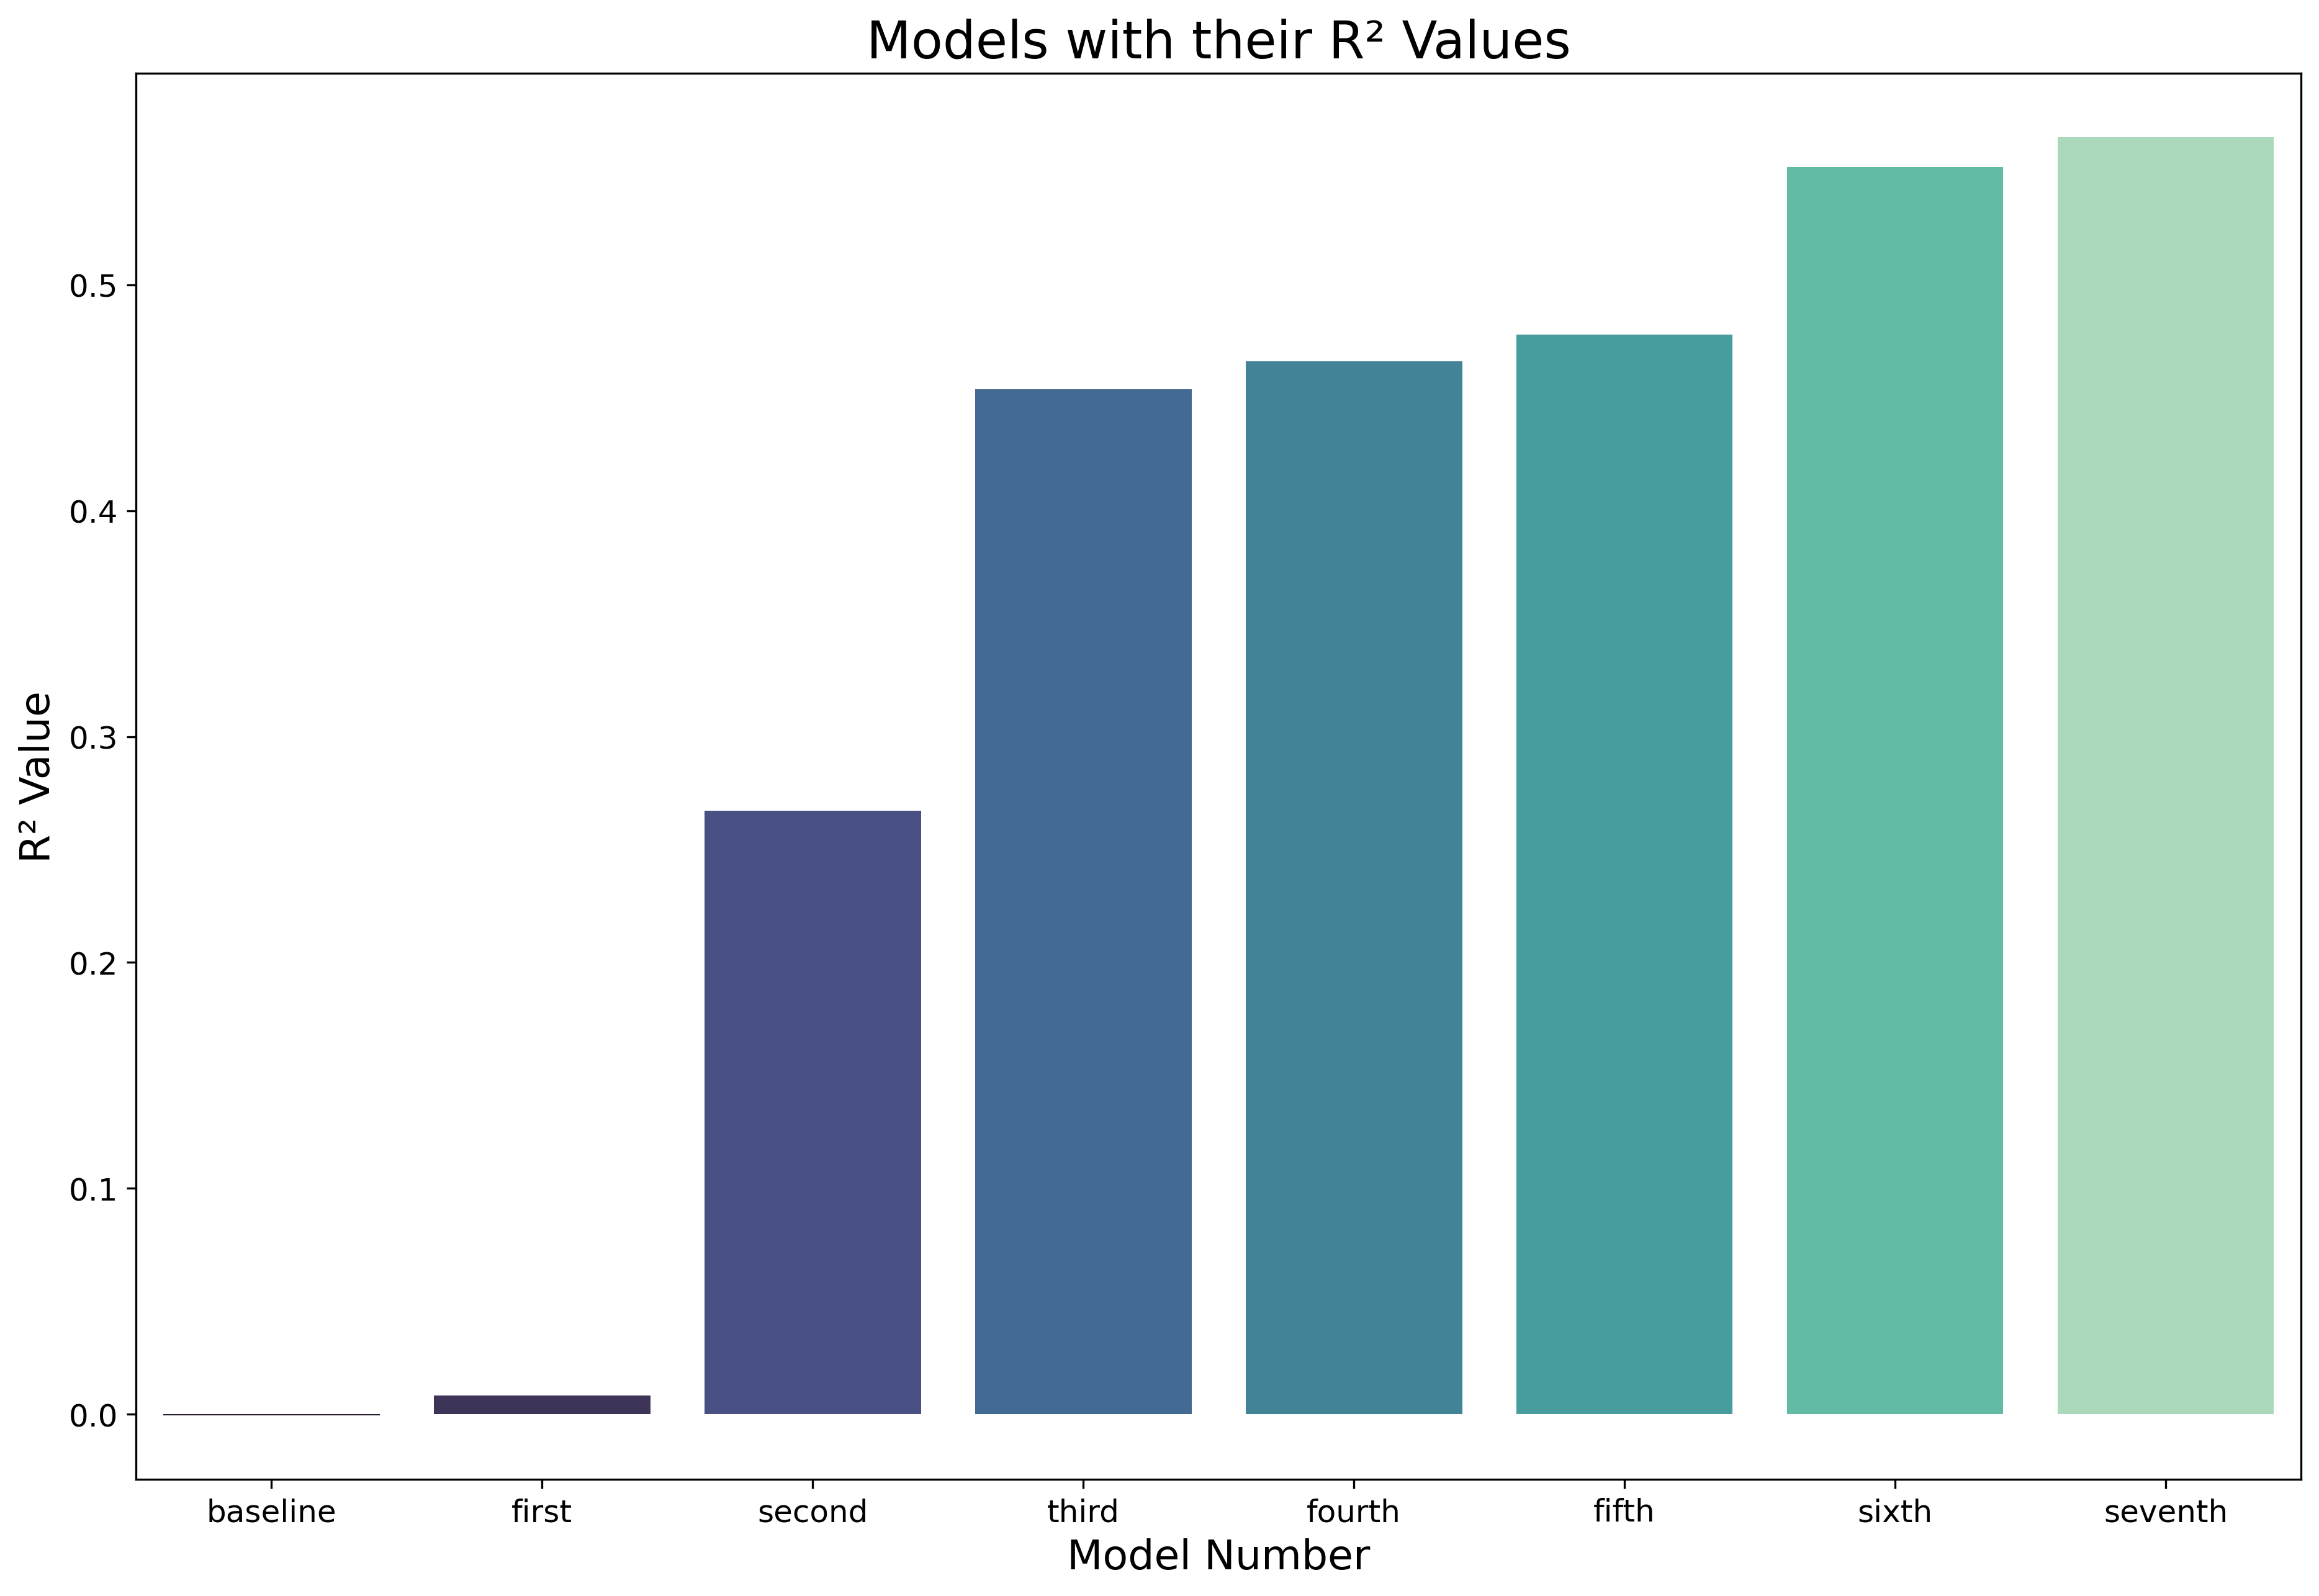

In [49]:
baseline = dummy_regr.score(X_test, Y_test)
first = lr1.score(X_test1, y_test1)
second = lr2.score(X_test2, y_test2)
third = lr3.score(X_test3, y_test3)
fourth = lr4.score(X_test4, y_test4)
fifth = lr5.score(X_test5, y_test5)
sixth = lr6.score(X_test6, y_test6)
seventh = lr7.score(X_test7, y_test7)

barchart = pd.DataFrame({'Model':['baseline', 'first', 'second',
                                  'third', 'fourth', 'fifth', 'sixth', 'seventh'],
                         'R\u00b2':[baseline, first, second, third, fourth, fifth, sixth, seventh]})
plt.figure(figsize=(15,10), dpi=300)
ax = sns.barplot(x=barchart['Model'], y=barchart['R\u00b2'], palette="mako")
plt.title("Models with their R\u00b2 Values", fontsize=20)
ax.set_xlabel('Model Number', fontsize=16)
ax.set_ylabel('R\u00b2 Value', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

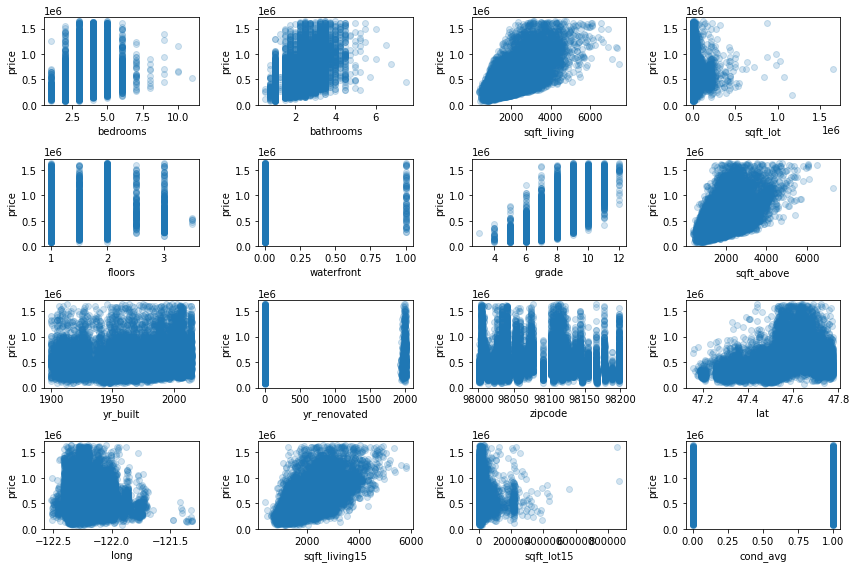

In [59]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(12, 8))
fig.set_tight_layout(True)

xcont = df.select_dtypes(('int64', 'float64')).columns.drop(['price'])


for xcol, ax in zip(xcont, axes.flatten()):
    ax.scatter(df[xcol], df['price'], alpha=0.2)
    ax.set_xlabel(xcol)
    ax.set_ylabel("price")

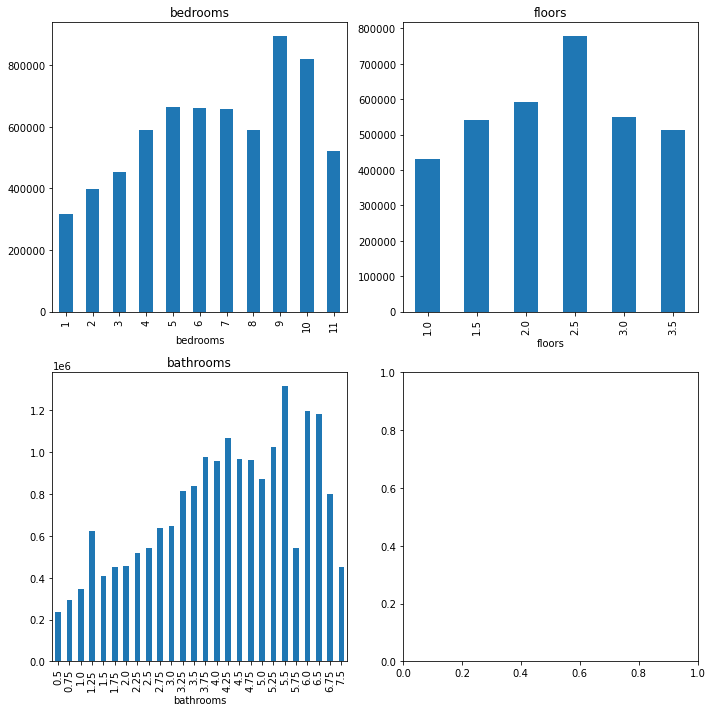

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10 , 10), sharey=False)

barchart = ['bedrooms', 'floors', 'bathrooms']

for x, ax in zip(barchart, axes.flatten()):
    df.groupby(x).mean()['price'].plot.bar(ax=ax)
    
    ax.set_title(x)  
    
    
fig.tight_layout()

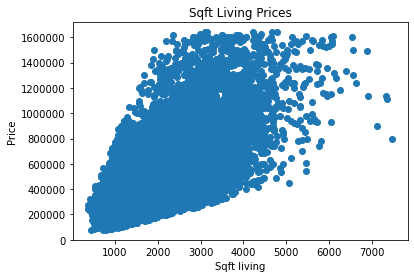

In [52]:
x = df['sqft_living']
y = df['price']

plt.ticklabel_format(style='plain')
plt.scatter(x, y)
plt.title('Sqft Living Prices')
plt.xlabel('Sqft living')
plt.ylabel('Price')
plt.show()

<AxesSubplot:>

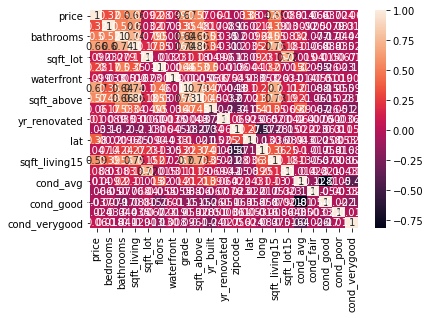

In [53]:
sns.heatmap(df.corr(),annot=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f99c1b529d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f99c1c0b0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f99c1b526a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f99c1c0b760>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f99c1c0ba90>],
 'means': []}

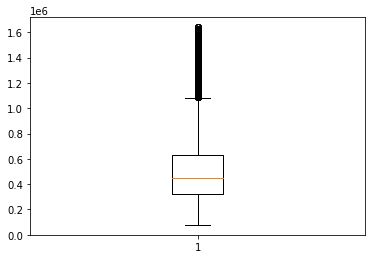

In [54]:
plt.boxplot(df['price'])

completely unstandardized distribution

In [55]:
lr7.coef_

array([-6.03736816e-02, -1.75383245e+04, -9.36032384e+03, -2.11976996e+03,
        1.34205570e+02,  2.94370225e+05, -5.18086074e+04, -4.82533811e+04,
        1.20045026e+03,  3.32636580e+04,  6.55978802e+04,  1.02906282e+05,
        5.46936607e+02])

In [56]:
plotdf = pd.DataFrame({'Predictor':['sqft_lot', 'bedrooms', 'bathrooms', 'floors','sqft_living', 'waterfront','cond_avg', 'cond_fair', 'cond_good', 'cond_poor', 'cond_verygood', 'grade', 'zipcode'],
                       'Coefficient':[-0.0603736816, -17538.3245, -9360.32384, -2119.76996, 134.205570, 294370.225, -51808.6074, -48253.3811, 1200.45026, 33263.6580, 65597.8802, 102906.282, 546.936607]})
plotdf = plotdf.sort_values(by=['Coefficient'])

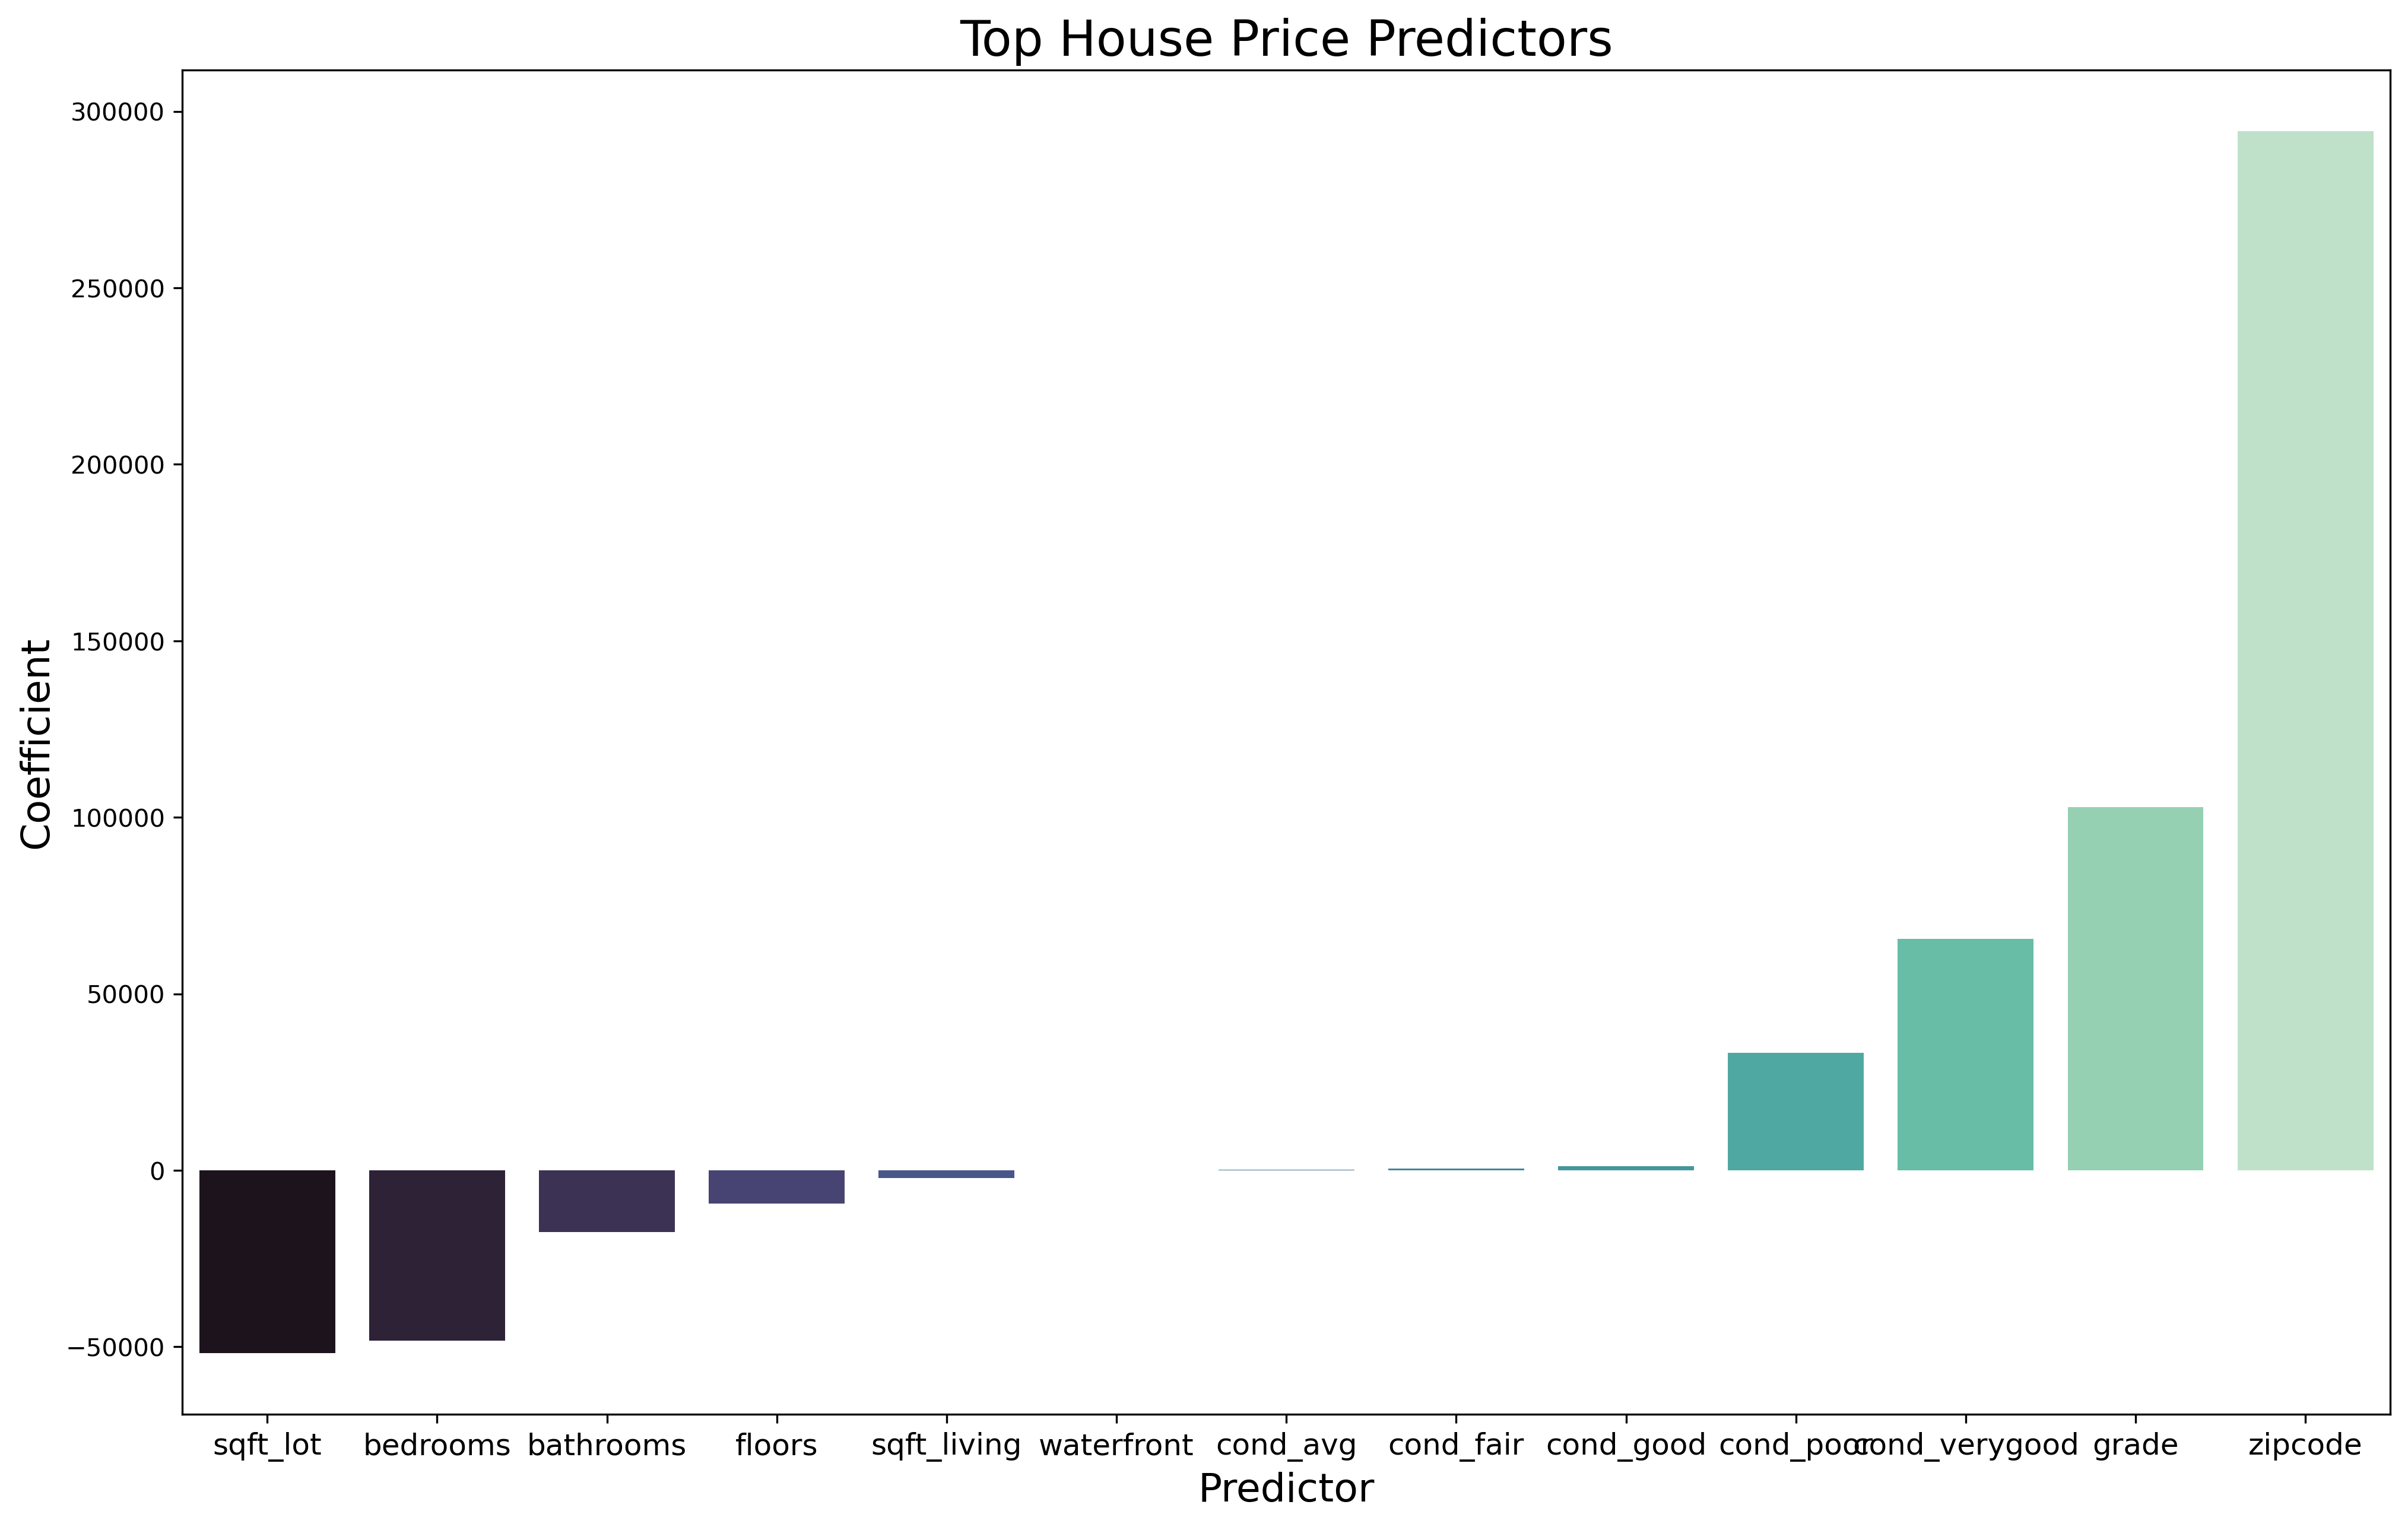

In [57]:
fig, ax = plt.subplots(figsize=(16,10), dpi=300)
ax = sns.barplot(x=plotdf['Predictor'], y=plotdf['Coefficient'], palette="mako",)
ax.set_title('Top House Price Predictors', fontsize=20)
ax.set_xlabel('Predictor', fontsize=16)
ax.set_ylabel('Coefficient', fontsize=16)
labels = ['sqft_lot', 'bedrooms', 'bathrooms', 'floors','sqft_living', 'waterfront','cond_avg', 'cond_fair', 'cond_good', 'cond_poor', 'cond_verygood', 'grade', 'zipcode']
ax.set_xticklabels(labels, fontsize=12);

# Conclusion
Of all the models I created my seventh and final was my best according to the R- squared, which was 55%, but most of the features didnt actually add value. I also got a rmse of 172022.53 which indicates my model is terrible. I recommend that I have more time to go back to the drawing board to get better predictions.